# Analysis of Cleaning Procedures

## Prerequisites

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataset import Dataset
from dataset_constants import *

from collections import Counter

RANDOM_SEED = 0

## Helper Functions

In [62]:
def plot_hate_freq(train_df, val_df, test_df):
    # Count occurrences of 0s and 1s for each set
    train_counts = train_df['label'].value_counts()
    validation_counts = val_df['label'].value_counts()
    test_counts = test_df['label'].value_counts()

    # Ensure both labels (0 and 1) exist in each set, even if they are zero
    train_counts = train_counts.reindex([0, 1], fill_value=0)
    validation_counts = validation_counts.reindex([0, 1], fill_value=0)
    test_counts = test_counts.reindex([0, 1], fill_value=0)

    # Calculate total counts for percentages
    train_total = train_counts.sum()
    val_total = validation_counts.sum()
    test_total = test_counts.sum()

    # Calculate percentages
    train_percent = train_counts / train_total * 100
    val_percent = validation_counts / val_total * 100
    test_percent = test_counts / test_total * 100

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))

    bar_width = 0.3  # Adjusted width of the bars to reduce spacing

    # Positions for bars
    train_positions = np.arange(len(train_counts))
    val_positions = np.arange(len(validation_counts)) + bar_width * 2
    test_positions = np.arange(len(test_counts)) + bar_width * 4

    # Plot stacked bars
    train_bars_not_hate = ax.bar(train_positions[0], train_counts[0], bar_width, label='Not Hate Speech', color='tab:blue')
    train_bars_hate = ax.bar(train_positions[0], train_counts[1], bar_width, bottom=train_counts[0], label='Hate Speech', color='tab:orange')

    val_bars_not_hate = ax.bar(val_positions[0], validation_counts[0], bar_width, label='Not Hate Speech', color='tab:blue')
    val_bars_hate = ax.bar(val_positions[0], validation_counts[1], bar_width, bottom=validation_counts[0], label='Hate Speech', color='tab:orange')

    test_bars_not_hate = ax.bar(test_positions[0], test_counts[0], bar_width, label='Not Hate Speech', color='tab:blue')
    test_bars_hate = ax.bar(test_positions[0], test_counts[1], bar_width, bottom=test_counts[0], label='Hate Speech', color='tab:orange')

    # Add labels, title, and legend
    ax.set_ylabel('Count')
    ax.set_title('Count of Hate Speech Labels by Dataset')

    # Create a custom legend with unique labels
    handles, labels = ax.get_legend_handles_labels()
    unique_handles = [handles[0], handles[1]]  # Select unique handles
    unique_labels = ['Not Hate Speech', 'Hate Speech']

    ax.legend(unique_handles, unique_labels)

    # Function to add labels and percentages on the bars
    def add_labels_and_percentages(bars, counts, percentages):
        for bar, count, percentage in zip(bars, counts, percentages):
            height = bar.get_height()
            if height > 0:
                x_pos = bar.get_x() + bar.get_width() / 2
                y_pos = bar.get_y() + height / 2
                ax.annotate(f'{count}\n({percentage:.1f}%)',
                            xy=(x_pos, y_pos),
                            xytext=(0, 5),
                            textcoords="offset points",
                            ha='center', va='center', color='white')

    # Add labels and percentages to "Not Hate Speech" and "Hate Speech" bars separately
    add_labels_and_percentages(train_bars_not_hate, [train_counts[0]], [train_percent[0]])
    add_labels_and_percentages(train_bars_hate, [train_counts[1]], [train_percent[1]])

    add_labels_and_percentages(val_bars_not_hate, [validation_counts[0]], [val_percent[0]])
    add_labels_and_percentages(val_bars_hate, [validation_counts[1]], [val_percent[1]])

    add_labels_and_percentages(test_bars_not_hate, [test_counts[0]], [test_percent[0]])
    add_labels_and_percentages(test_bars_hate, [test_counts[1]], [test_percent[1]])

    plt.tight_layout()
    plt.show()

## Original Uncleaned Data

In [19]:
dataset_uncleaned = Dataset(train_path=TRAIN_DATASET_PATH,
                  val_path=VALIDATION_DATASET_PATH, 
                  test_path=TEST_DATASET_PATH)
dataset_uncleaned.build()

X_train_uncleaned = dataset_uncleaned.get_features(split_type="train")
Y_train_uncleaned = dataset_uncleaned.get_labels(split_type="train")
X_val_uncleaned = dataset_uncleaned.get_features(split_type="val")
Y_val_uncleaned = dataset_uncleaned.get_labels(split_type="val")
X_test_uncleaned = dataset_uncleaned.get_features(split_type="test")
Y_test_uncleaned = dataset_uncleaned.get_labels(split_type="test")

In [66]:
X_train_uncleaned

['Inaasahan na ni Vice President Jejomar Binay na may mga taong... https://t.co/SDytgbWiLh',
 'Mar Roxas TANG INA TUWID NA DAAN DAW .. EH SYA NGA DI STRAIGHT',
 'Salamat sa walang sawang suporta ng mga taga makati! Ang Pagbabalik Binay In Makati #OnlyBinayInMakatiSanKaPa https://t.co/iwAOdtZPRE',
 '@rapplerdotcom putangina mo binay TAKBO PA',
 'Binay with selective amnesia, forgetting about the past six years he spent preparing to be president.  #PiliPinasDebates2016',
 "It doesn't matter whoever won between Duterte &amp; Miriam as President. As long as they finally changed the country Noynoy failed to do so.",
 'Nognog? Pero nognog din ang nag malasakit? Wtf? Tangina mo Binay nagpapaawa kapa! Hahahahaha #Nognog ??',
 '#OnlyB1nay ?? #FB https://t.co/QEQnsK67Gm',
 'What Abi Binay said on running for Makati mayor #Halalan2016 https://t.co/ayxM39JKNx https://t.co/rHhl4LfMaa',
 'Srsly. How can Binay do away with no tax for those earning PhP 30k and below without any compromises? Nkklk tala

# Part I. Cleaned Dataset with Duplicates

The following preprocessing was performed:
- Removed URLs and usernames
- Removed numeric words
- Convert all text to lowercase
- Removed 'rt'
- Expanded contractions
- Removed punctuations
- Removed stopwords

In [2]:
dataset_v1 = Dataset(full_data_path='cleaned_dataset_w_dupes.pkl',
                  from_scratch=False,
                  split_sizes=[10000, 4232, 4232])
dataset_v1.build()

X_train = dataset_v1.get_features(split_type="train")
Y_train = dataset_v1.get_labels(split_type="train")
X_val = dataset_v1.get_features(split_type="val")
Y_val = dataset_v1.get_labels(split_type="val")
X_test = dataset_v1.get_features(split_type="test")
Y_test = dataset_v1.get_labels(split_type="test")

Data loaded from cleaned_dataset_w_dupes.pkl


In [34]:
# Convert to pandas df
train_df = pd.DataFrame(
    {'tweets': X_train,
     'label': Y_train
    })

val_df = pd.DataFrame(
    {'tweets': X_val,
     'label': Y_val
    })

test_df = pd.DataFrame(
    {'tweets': X_test,
     'label': Y_test
    })

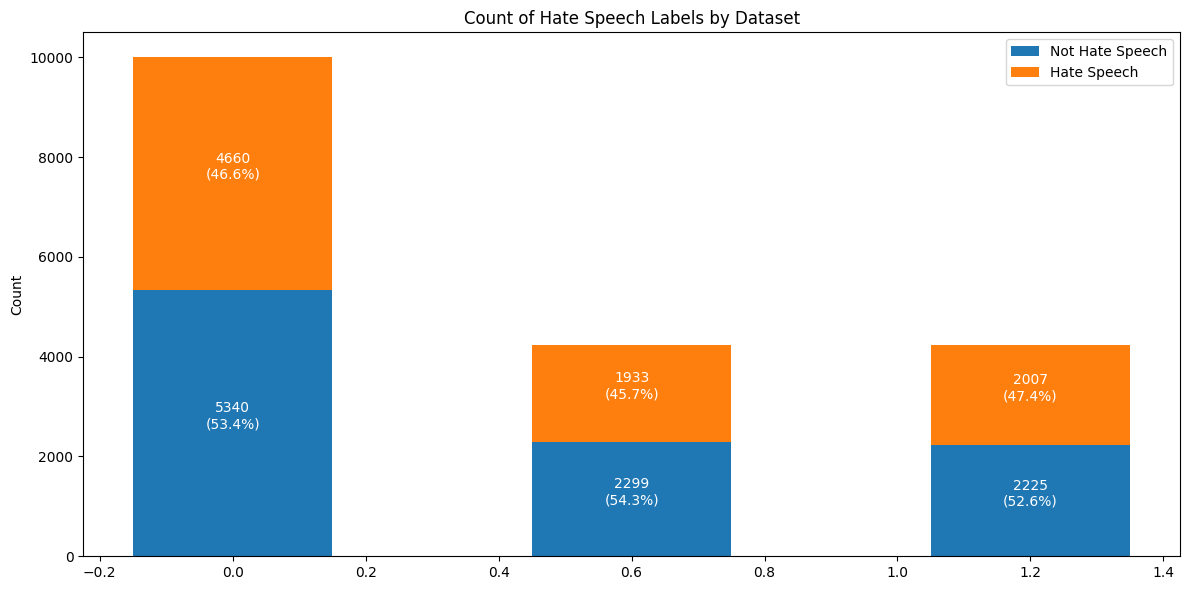

In [65]:
plot_hate_freq(train_df,val_df,test_df)

## Analysis of Duplicates

In [16]:
# Count the occurrences in each set
train_counts = Counter(X_train)
val_counts = Counter(X_val)
test_counts = Counter(X_test)

# Create a DataFrame
df_train = pd.DataFrame(train_counts.items(), columns=['Tweet', 'Train_Count'])
df_val = pd.DataFrame(val_counts.items(), columns=['Tweet', 'Val_Count'])
df_test = pd.DataFrame(test_counts.items(), columns=['Tweet', 'Test_Count'])

# Merge DataFrames on 'Tweet'
df = pd.merge(df_train, df_val, on='Tweet', how='outer')
df = pd.merge(df, df_test, on='Tweet', how='outer')

# Fill NaN values with 0 (in case some tweets are missing in some sets)
df = df.fillna(0).astype({'Train_Count': 'int', 'Val_Count': 'int', 'Test_Count': 'int'})

# Calculate total count across train, val, and test
df['Total_Count'] = df['Train_Count'] + df['Val_Count'] + df['Test_Count']

# Filter out rows where the total count is 1 or 0
df_filtered = df[df['Total_Count'] > 1]

# Display the filtered DataFrame
df_filtered.head()

,Tweet,Train_Count,Val_Count,Test_Count,Total_Count
0,,59,24,32,115
17,2016nurseryrhymes,3,0,0,3
23,2nd mar roxas,1,1,0,2
98,abigail binay claims peña shut district office...,1,0,1,2
105,abscbn advertisement mar roxas duterte,2,0,0,2


In [17]:
df_filtered

,Tweet,Train_Count,Val_Count,Test_Count,Total_Count
0,,59,24,32,115
17,2016nurseryrhymes,3,0,0,3
23,2nd mar roxas,1,1,0,2
98,abigail binay claims peña shut district office...,1,0,1,2
105,abscbn advertisement mar roxas duterte,2,0,0,2
...,...,...,...,...,...
16351,yaman binay commercial noontime gma tapos haba...,0,2,0,2
16394,yes believe mar roxas quoted context context a...,0,2,0,2
16445,youthformiriam,2,0,0,2
16497,“personally end” isabela gov faustino dy said ...,1,0,1,2


In [67]:
df_filtered

,Tweet,Train_Count,Val_Count,Test_Count,Total_Count
0,,59,24,32,115
17,2016nurseryrhymes,3,0,0,3
23,2nd mar roxas,1,1,0,2
98,abigail binay claims peña shut district office...,1,0,1,2
105,abscbn advertisement mar roxas duterte,2,0,0,2
...,...,...,...,...,...
16351,yaman binay commercial noontime gma tapos haba...,0,2,0,2
16394,yes believe mar roxas quoted context context a...,0,2,0,2
16445,youthformiriam,2,0,0,2
16497,“personally end” isabela gov faustino dy said ...,1,0,1,2


In [26]:
# Function to check for empty rows and get corresponding uncleaned tweets and labels
def check_empty_rows(cleaned_data, uncleaned_data, labels, set_name):
    empty_indices = [i for i, tweet in enumerate(cleaned_data) if tweet == ""]
    if empty_indices:
        empty_uncleaned_tweets = [(uncleaned_data[i], labels[i]) for i in empty_indices]
        print(f"Empty rows in {set_name}: {empty_indices}")
        return empty_uncleaned_tweets
    else:
        print(f"No empty rows in {set_name}")
        return []

# Check each set for empty rows and compile the uncleaned tweets and labels
empty_train_uncleaned = check_empty_rows(X_train, X_train_uncleaned, Y_train, "Train set")
empty_val_uncleaned = check_empty_rows(X_val, X_val_uncleaned, Y_val, "Validation set")
empty_test_uncleaned = check_empty_rows(X_test, X_test_uncleaned, Y_test, "Test set")

# Combine all empty uncleaned tweets and labels into one list
all_empty_uncleaned = empty_train_uncleaned + empty_val_uncleaned + empty_test_uncleaned

# Display the list of empty uncleaned tweets with their labels
print("\nList of empty uncleaned tweets with their labels:")
for tweet, label in all_empty_uncleaned:
    print(f"Tweet: '{tweet}', Label: {label}")


Empty rows in Train set: [339, 512, 525, 575, 612, 892, 1053, 1293, 1373, 1427, 1508, 1586, 1691, 2263, 2466, 3332, 3369, 3398, 3519, 3587, 3605, 3880, 4218, 4346, 4414, 4866, 4916, 4999, 5224, 5264, 5354, 5533, 5537, 5724, 5805, 6033, 6204, 6292, 6412, 6533, 6860, 7371, 7380, 7691, 7712, 7829, 8317, 8608, 8658, 8796, 8933, 9135, 9195, 9253, 9672, 9919, 9975, 9977, 9996]
Empty rows in Validation set: [33, 198, 275, 468, 581, 949, 1214, 1640, 1642, 2100, 2505, 2525, 2601, 2674, 2789, 3117, 3175, 3329, 3367, 3567, 3627, 3856, 3871, 4204]
Empty rows in Test set: [160, 308, 377, 783, 895, 938, 978, 1360, 1418, 1429, 1476, 1636, 1708, 1821, 1882, 2047, 2053, 2269, 2344, 2355, 2619, 2800, 3021, 3289, 3433, 3708, 3738, 3762, 3890, 3951, 3978, 4156]

List of empty uncleaned tweets with their labels:
Tweet: 'https://t.co/dCvxRlisoq https://t.co/8vTgG4jxns', Label: 0
Tweet: 'https://t.co/pr0255PlN9 https://t.co/k8so9Ui1Yo', Label: 1
Tweet: 'https://t.co/ybU4cttLt2', Label: 0
Tweet: 'https://t.co

In [30]:
df_filtered.sort_values(by='Test_Count', ascending=False)

,Tweet,Train_Count,Val_Count,Test_Count,Total_Count
0,,59,24,32,115
1244,binay,50,23,24,97
11672,pilipinasdebates2016,38,6,15,59
8065,mar roxas,21,7,13,41
10946,onlybinaypriority4ps,26,4,12,42
...,...,...,...,...,...
6397,jejomar binay,2,2,0,4
6384,jake ejercito sandro marcos seb duterte paolo ...,1,1,0,2
6318,isabela governor powerful political dynasty en...,1,1,0,2
6290,investors wary binay win–eiu voteph2016,3,0,0,3
